In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
from fastai.conv_learner import *
from fastai.dataset import *

import json, pdb
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
import pandas as pd

In [4]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.set_xticks(np.linspace(0, 224, 8))
    ax.set_yticks(np.linspace(0, 224, 8))
    ax.grid()
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    return ax

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b, color='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)

def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt,
        verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1],a[2]-a[0]])

    
def draw_im(im, ann):
    ax = show_img(im, figsize=(16,8))
    for b,c in ann:
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], cats[c], sz=16)

def draw_idx(i):
    im_a = trn_anno[i]
    im = open_image(IMG_PATH/trn_fns[i])
    draw_im(im, im_a)

In [5]:
PATH = Path('data/pascal')
list(PATH.iterdir())

[PosixPath('data/pascal/tmp'),
 PosixPath('data/pascal/all_info.csv'),
 PosixPath('data/pascal/VOC2012'),
 PosixPath('data/pascal/pascal_val2012.json'),
 PosixPath('data/pascal/pascal_test2007.json'),
 PosixPath('data/pascal/pascal_val2007.json'),
 PosixPath('data/pascal/lrg_bbox.csv'),
 PosixPath('data/pascal/VOC2007'),
 PosixPath('data/pascal/models'),
 PosixPath('data/pascal/mult_cat.csv'),
 PosixPath('data/pascal/mult_bbox.csv'),
 PosixPath('data/pascal/VOCtrainval_11-May-2012.tar'),
 PosixPath('data/pascal/pascal_train2012.json'),
 PosixPath('data/pascal/pascal_train2007.json'),
 PosixPath('data/pascal/lrg_cat.csv'),
 PosixPath('data/pascal/VOCtrainval_06-Nov-2007.tar')]

In [6]:
JPEGS = 'VOC2007/JPEGImages'
IMG_PATH = PATH/JPEGS

In [7]:
all_df = pd.read_csv(PATH / 'all_info.csv')
mult_cat= pd.read_csv(PATH / 'mult_cat.csv')
mult_bbox= pd.read_csv(PATH / 'mult_bbox.csv') 

In [8]:
mult_bbox.head()

,file_name,bbox
0,000012.jpg,96 155 269 350
1,000017.jpg,61 184 198 278 77 89 335 402
2,000023.jpg,229 8 499 244 219 229 499 333 0 1 368 116 1 2 ...
3,000026.jpg,124 89 211 336
4,000032.jpg,77 103 182 374 87 132 122 196 179 194 228 212 ...


In [9]:
all_df.shape

(7844, 11)

In [10]:
cats=all_df[['category_id','cat_name']].drop_duplicates().values

In [11]:
id2cat = {i[0]-1:i[1] for i in cats}
cat2id = {i[1]:i[0]-1 for i in cats}

In [12]:
mcs=np.array([np.array([cat2id[j] for j in i.split(' ')]) for i in mult_cat.cat_name.values ])
mcs

array([array([6]), array([14, 12]), array([ 1,  1, 14, 14, 14]), ..., array([17,  8, 14, 14, 14]),
       array([6]), array([11])], dtype=object)

In [13]:
val_idxs = get_cv_idxs(mult_bbox.shape[0])
((val_mcs,trn_mcs),) = split_by_idx(val_idxs, mcs)

In [14]:
val_mcs[:5]

array([array([ 1, 14, 14]), array([11, 17]), array([2]), array([14]), array([14, 14, 14, 14, 14,  4,  4])],
      dtype=object)

In [15]:
f_model=resnet34
sz=224
bs=16

In [16]:
MBB_CSV = PATH / 'mult_bbox.csv'
aug_tfms = [RandomRotate(10, tfm_y=TfmType.COORD),
            RandomLighting(0.05, 0.05, tfm_y=TfmType.COORD),
            RandomFlip(tfm_y=TfmType.COORD)]
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=aug_tfms)
md = ImageClassifierData.from_csv(PATH, JPEGS, MBB_CSV, tfms=tfms, continuous=True, num_workers=4)

In [17]:
# function and library for plotting corloful bounding boxes
import matplotlib.cm as cmx
import matplotlib.colors as mcolors
from cycler import cycler

def get_cmap(N):
    color_norm  = mcolors.Normalize(vmin=0, vmax=N-1)
    return cmx.ScalarMappable(norm=color_norm, cmap='Set3').to_rgba

num_colr = 12
cmap = get_cmap(num_colr)
colr_list = [cmap(float(x)) for x in range(num_colr)]

In [18]:
def show_ground_truth(ax, im, bbox, clas=None, prs=None, thresh=0.3):
    bb = [bb_hw(o) for o in bbox.reshape(-1,4)]
    if prs is None:  prs  = [None]*len(bb)
    if clas is None: clas = [None]*len(bb)
    ax = show_img(im, ax=ax)
    for i,(b,c,pr) in enumerate(zip(bb, clas, prs)):
        if((b[2]>0) and (pr is None or pr > thresh)):
            draw_rect(ax, b, color=colr_list[i%num_colr])
            txt = f'{i}: '
            if c is not None: txt += ('bg' if c==len(id2cat) else id2cat[c])
            if pr is not None: txt += f' {pr:.2f}'
            draw_text(ax, b[:2], txt, color=colr_list[i%num_colr])

In [19]:
class ConcatLblDataset(Dataset): 
    # create new dataset with original X and new y which is a tuple: (y_bbox,y_label)
    # inherit torch Dataset
    
    def __init__(self, ds, y2): 
        self.ds,self.y2 = ds,y2
        self.sz = ds.sz
    #self.ds contains np array X and y of bbox dataset
    def __len__(self): return len(self.ds)
    
    def __getitem__(self, i):
        x,y = self.ds[i]
        return (x, (y,self.y2[i])) # (X,(y_bbox,y_label))

In [20]:
md.trn_ds[1][0].shape
md.trn_ds[1][1].shape

(3, 224, 224)

(8,)

In [21]:
# md.trn_ds (created from ImageClassifierData.from_csv) and trn_mcs (from get_cv_idxs) have same indices
# as .from_csv also used get_cv_idxs func
trn_ds2 = ConcatLblDataset(md.trn_ds, trn_mcs)
val_ds2 = ConcatLblDataset(md.val_ds, val_mcs)
md.trn_dl.dataset = trn_ds2
md.val_dl.dataset = val_ds2

In [38]:
md.trn_ds[1][0].shape
md.trn_ds[1][1][0].shape
md.trn_ds[1][1][1].shape

(3, 224, 224)

(8,)

(2,)

In [39]:
x,y=to_np(next(iter(md.trn_dl)))
x=md.trn_ds.ds.denorm(x)
x.shape

(64, 224, 224, 3)

In [33]:
y[0].shape # largest # of bbox assigned to an img * 4 (4 coords)
y[1].shape # largest # of labels assigned to an img for this dataset

(64, 52)

(64, 13)

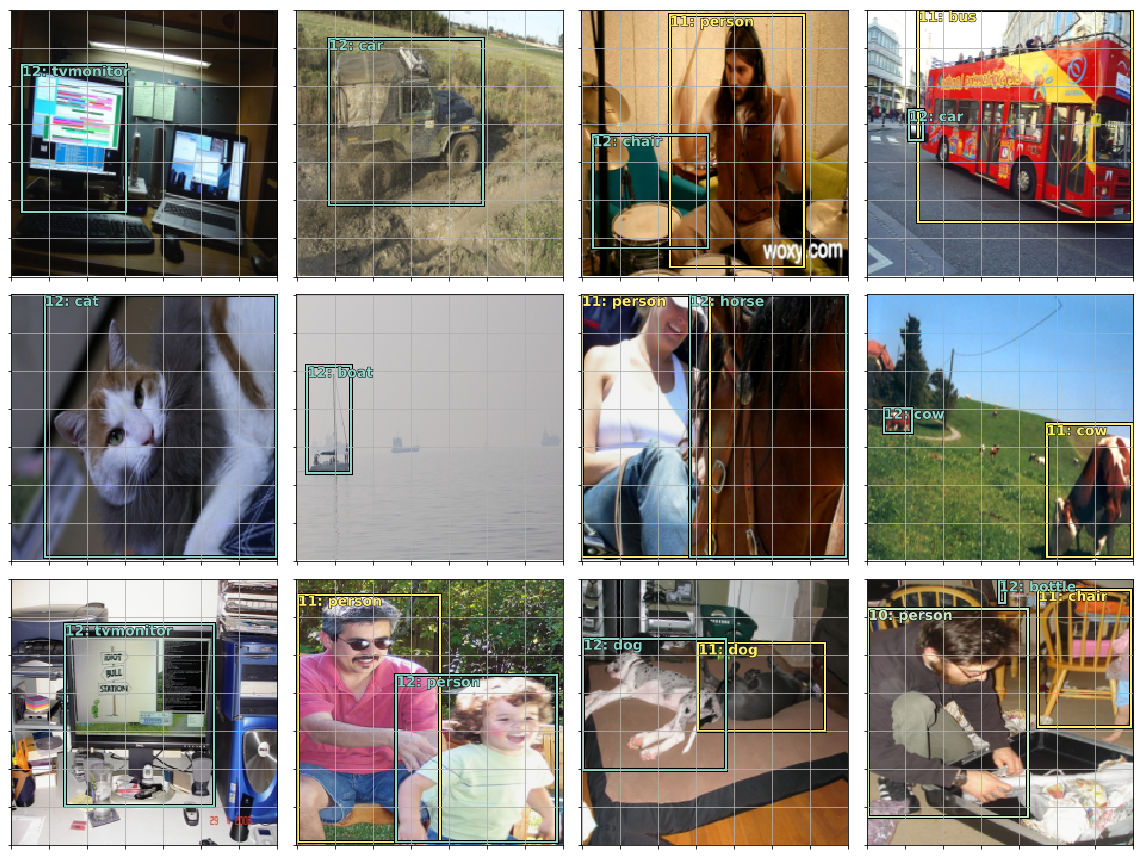

In [23]:

fig, axes = plt.subplots(3, 4, figsize=(16, 12))
for i,ax in enumerate(axes.flat):
    show_ground_truth(ax, x[i], y[0][i], y[1][i])
plt.tight_layout()

# Simple model: predict obj for each cell of a 4x4 grid

In [24]:
anc_grid = 4
k = 1

anc_offset = 1/(anc_grid*2)
anc_x = np.tile(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid)
anc_y = np.repeat(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid)

anc_ctrs = np.tile(np.stack([anc_x,anc_y], axis=1), (k,1))
anc_sizes = np.array([[1/anc_grid,1/anc_grid] for i in range(anc_grid*anc_grid)])
anchors = V(np.concatenate([anc_ctrs, anc_sizes], axis=1), requires_grad=False).float()

In [25]:
grid_sizes = V(np.array([1/anc_grid]), requires_grad=False).unsqueeze(1)

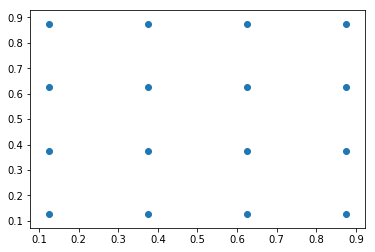

In [26]:
plt.scatter(anc_x, anc_y)

In [27]:
anchors.shape

torch.Size([16, 4])

In [28]:
def hw2corners(ctr, hw): return torch.cat([ctr-hw/2, ctr+hw/2], dim=1)
anchor_cnr = hw2corners(anchors[:,:2], anchors[:,2:])
anchor_cnr

Variable containing:
 0.0000  0.0000  0.2500  0.2500
 0.2500  0.0000  0.5000  0.2500
 0.5000  0.0000  0.7500  0.2500
 0.7500  0.0000  1.0000  0.2500
 0.0000  0.2500  0.2500  0.5000
 0.2500  0.2500  0.5000  0.5000
 0.5000  0.2500  0.7500  0.5000
 0.7500  0.2500  1.0000  0.5000
 0.0000  0.5000  0.2500  0.7500
 0.2500  0.5000  0.5000  0.7500
 0.5000  0.5000  0.7500  0.7500
 0.7500  0.5000  1.0000  0.7500
 0.0000  0.7500  0.2500  1.0000
 0.2500  0.7500  0.5000  1.0000
 0.5000  0.7500  0.7500  1.0000
 0.7500  0.7500  1.0000  1.0000
[torch.cuda.FloatTensor of size 16x4 (GPU 0)]

In [29]:
anchor_cnr.shape

torch.Size([16, 4])

In [32]:
n_clas = len(id2cat)+1; n_clas
n_act = k*(4+n_clas); n_act


21

25

# Custom head for SSD

Reminder: 
- Last layer from the resnetblock is
```
(2): BasicBlock(
     (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
     (relu): ReLU(inplace)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
   )
 )]
```

- Custom head (attach to above layer) for 1 bbox and 1 label is:
```
head_reg4 = nn.Sequential(
    Flatten(),
    nn.ReLU(),
    # No need for a batchnorm here since last resnetblock already have it
    nn.Dropout(0.5),
    nn.Linear(25088,256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    nn.Linear(256,4+len(cats)), # predict 4 bbox coords + 20 cats at the same time
    # Note that there is no softmax or sigmoid activation applied to the last layer
)
```

Last layer from the resnetblock is

In [40]:
def flatten_conv(x,k): 
    '''
    x.size is either (bs,# labels,4,4) or (bs,# of coord,4,4)
    Transform x into (bs,# labels/coord, 16) then (bs,16,# labels/coord)
    '''
    
    return x.view(x.size(0),x.size(1)//k,-1).transpose(1,2)

class StdConv(nn.Module):
    '''
    A standard conv->relu->batch_norm-> dropout block
    '''
    def __init__(self, nin, nout, stride=2, drop=0.1):
        super().__init__()
        self.conv = nn.Conv2d(nin, nout, 3, stride=stride, padding=1)
        self.bn = nn.BatchNorm2d(nout)
        self.drop = nn.Dropout(drop)
        
    def forward(self, x): return self.drop(self.bn(F.relu(self.conv(x))))
        


class OutConv(nn.Module):
    '''
    '''
    def __init__(self, k, nin, bias):
        super().__init__()
        self.k = k
        
        # both of conv2d below are stride 1
        # oconv1 predict labels: 4x4x256 to 4x4x(# labels + 1 for background)
        self.oconv1 = nn.Conv2d(nin, (len(id2cat)+1)*k, 3, padding=1)
        
        # oconv2 predict bbox coord: 4x4x256 to 4x4x4
        self.oconv2 = nn.Conv2d(nin, 4*k, 3, padding=1)
        
        # zero reset and add some constant (bias) to 
        #   label-predictoin conv2d bias. TODO: why?
        self.oconv1.bias.data.zero_().add_(bias)
        
    def forward(self, x):
        # (bs,256,4,4) to [(bs,16,21 ),(bs,16,4)]
        return [flatten_conv(self.oconv1(x), self.k),
                flatten_conv(self.oconv2(x), self.k)]
        

def flatten_conv(x,k): return x.view(x.size(0),x.size(1)//k,-1).transpose(1,2)

    
class SSD_Head(nn.Module):
    def __init__(self, k, bias):
        super().__init__()
        self.drop = nn.Dropout(0.25)
        
        # start with stride 1: not change height x width, only # channels
        # ''mini neural net' using conv2d
        self.sconv0 = StdConv(512,256, stride=1)
        
#         self.sconv1 = StdConv(256,256)
        self.sconv2 = StdConv(256,256) # stride 2 -> turn 7x7x256 to 4x4x256
        self.out = OutConv(k, 256, bias)
        
    def forward(self, x):
        x = self.drop(F.relu(x))
        x = self.sconv0(x) # (bs,512,7,7) to (bs,512,7,7)
#         x = self.sconv1(x)
        x = self.sconv2(x) # (bs,512,7,7) to (bs,256,4,4) b/c stride 2
        return self.out(x) # (bs,256,4,4) to 

In [41]:
head_reg4 = SSD_Head(k, -3.)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4)
learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam
k

1